<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> We need to add the deterministic process to the training data. We need to find out how to implement lagged variables, we need to discuss whether,we should use future values as well. 

In [492]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

from statsmodels.tsa.deterministic import DeterministicProcess

In [541]:
df = pd.read_csv('Preprocessed_data.csv')


df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date', 'Salmon_exp_price'], axis=1, inplace=True)

In [484]:
# dp_train = DeterministicProcess(
#     index=X_train.index,
#     constant=True,
#     order=1,
#     drop=True
# )

In [485]:
# dp_train.in_sample()

In [542]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)

In [543]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

In [483]:
# def lagged_vars(X):
#     vol = [1,2,3,4,5]
#     fx = []

In [556]:
def det_process(X):
    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        drop=True
    )
    new_X = pd.concat([X,dp.in_sample()], axis=1)
    return new_X
processs = FunctionTransformer(func=det_process)


def log_transformation(X):
    X['FX_EURONOK'] = np.log1p(X['FX_EURONOK'])
    return X
loger = FunctionTransformer(func=log_transformation)

normalizer = StandardScaler()

def reshaper(X):
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])    
    return   X_reshaped
reshape = FunctionTransformer(func=reshaper)



model = keras.Sequential([
    layers.LSTM(3, input_shape=(1,5)),
    layers.Dropout(0.4),
    layers.Dense(8, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dense(2, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam',
              loss='mae')

In [562]:
X_test

,FX_EURONOK,Interest_rate,Food_index
Date,,,
2019-05-27,9.76837,0.50,95.340978
2019-06-03,9.80312,0.50,95.086631
2019-06-10,9.76780,0.50,95.086631
2019-06-17,9.65683,0.50,95.086631
2019-06-24,9.67580,0.50,95.086631
...,...,...,...
2023-11-27,11.61061,2.25,114.626222
2023-12-04,11.73763,2.50,112.403991
2023-12-11,11.42400,2.50,112.403991


In [564]:
pred

,FX_EURONOK,Interest_rate,Food_index,const,trend
Date,,,,,
2019-05-27,2.376613,0.50,95.340978,1.0,1.0
2019-06-03,2.379835,0.50,95.086631,1.0,2.0
2019-06-10,2.376560,0.50,95.086631,1.0,3.0
2019-06-17,2.366201,0.50,95.086631,1.0,4.0
2019-06-24,2.367979,0.50,95.086631,1.0,5.0
...,...,...,...,...,...
2023-11-27,2.534539,2.25,114.626222,1.0,236.0
2023-12-04,2.544561,2.50,112.403991,1.0,237.0
2023-12-11,2.519630,2.50,112.403991,1.0,238.0


In [563]:
my_pipe = Pipeline(steps=[
    ('pro', processs),
    ('log', loger),
    # ('scaler', normalizer),
    # ('res', reshape),
    # ('lstm', model)
])

# my_pipe.fit(X_train, y_train, lstm__epochs=20, lstm__batch_size=100)
# train_pred = my_pipe.predict(X_train)
# test_pred = my_pipe.predict(X_test)

my_pipe.fit(X_train, y_train)
pred = my_pipe.transform(X_test)

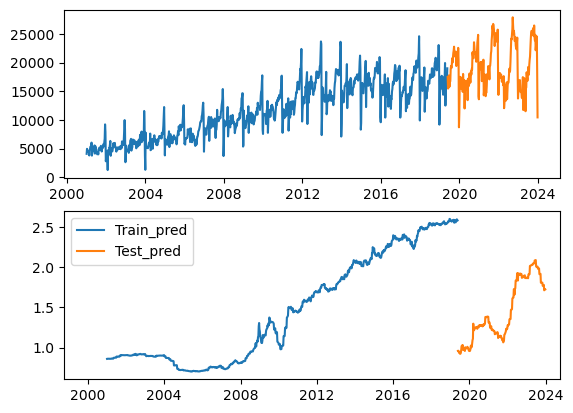

In [558]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_test, label='Test')

ax[1].plot(X_train.index, train_pred, label='Train_pred')
ax[1].set_xlim(10500,20000)
ax[1].plot(X_test.index, test_pred, label='Test_pred')

plt.legend()
plt.show()

In [538]:
cols = ['a','b','c']
a =  [pred[i][0][0] for i in range(0,len(pred),1)]
b =  [pred[i][0][1] for i in range(0,len(pred),1)]
c =  [pred[i][0][2] for i in range(0,len(pred),1)]

new_df =  pd.DataFrame([a,b,c])
new_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
955    0
956    0
957    0
958    0
959    0
Length: 960, dtype: int64

In [539]:
bol = new_df.isnull().sum()

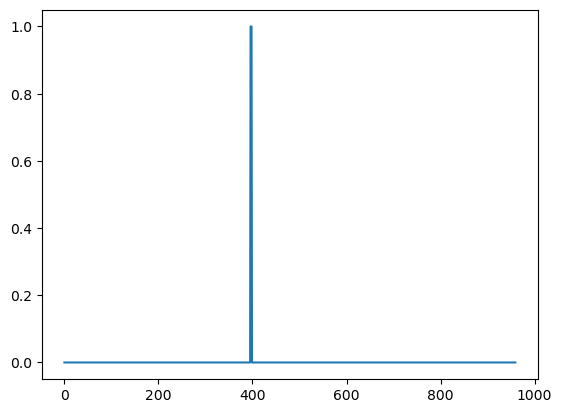

In [540]:
plt.plot(bol)